<a href="https://colab.research.google.com/github/prometheus404/AMD_project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##### DOWNLOAD DATASET #####
from IPython.display import clear_output
from google.colab import files
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d gsimonx37/letterboxd
!unzip /content/letterboxd.zip -d /content/letterbox/
clear_output()
############################

In [1]:
########### SPARK CONTEXT #####################
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better

sc = spark.sparkContext
###############################################

In [17]:
import pandas as pd
import itertools
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [3]:
N_BASKETS = 35000       #0 for full dataset
SPARK_CREATION = False  #initialize the RDD using spark instead of pandas to read the file

############## BASKET CREATION ################
if(SPARK_CREATION == False):
  actors = pd.read_csv("letterbox/actors.csv")
  actors = actors
  baskets = actors.groupby("id")["name"].apply(list)
  if(N_BASKETS > 0):
    baskets = baskets.sample(N_BASKETS, random_state = 42)

  print("number of baskets: " + str(len(baskets)))
  print("biggest basket: " + str(baskets.map(len).max()))
  print(baskets)
  baskets_RDD = sc.parallelize(baskets).cache()
  n_baskets = len(baskets)
else:
  RDD = sc.textFile("letterbox/actors.csv").map(lambda x: tuple(x.split(',')[:2])) #read from csv and split
  RDD = RDD.filter(lambda x: x != ('id','name')) #filter out the header
  RDD = RDD.groupByKey().mapValues(list).values()
  if(N_BASKETS > 0):
    baskets_RDD = RDD.sample(False, N_BASKETS/RDD.count(), seed = 42).cache() #fixed but different for each iteration seed
  else:
    baskets_RDD = RDD.cache()
  n_baskets = baskets_RDD.count()
print(n_baskets)
##############################################

number of baskets: 35000
biggest basket: 210
id
1850862                                   [Friedhelm Funkel]
1189772    [Derek Jacobi, Kenneth Branagh, Richard Easton...
1139390    [Dawn Murphy, Tina Krause, Gary Whitson, Deana...
1645732                                          [Jake Ryan]
1234913    [Nicoll Bacharach, Patrick B. Johnson, Robert ...
                                 ...                        
1373074    [Nathaniel Chi, Jim Lau, Yin Yin Liow, Cristia...
1113433                         [Mel Blanc, Robert C. Bruce]
1180017    [David Cardoso, Tássia Camargo, Helena Ramos, ...
1516932      [Namit Das, Renuka Shahane, Rajeshwari Sachdev]
1871260                                  [Feng Hu, Lu Yukun]
Name: name, Length: 35000, dtype: object
35000


In [4]:
## APRIORI
def apriori(chunk, s, tot_bsk):

  n_bsk = 0 # number of baskets in chunk used to calculate support
  count = dict() # should be relatively efficient since is a hash table

  def incr(e,dic):
    if e in dic:
      dic[e] += 1
    else:
      dic[e] = 1

  chunk = list(chunk) # to avoid consuming after first pass
  ### first pass
  for bsk in chunk:
    n_bsk += 1;
    #elements = [translate(x,trsl) for x in bsk]
    for b in bsk:
      incr(b,count)

  ### filter
  frequent = []
  for c in count:
    if count[c] >= s* n_bsk/tot_bsk:
      frequent.append(c)

  count = dict()
  for bsk in tqdm(chunk):
    #filter only members of C_2
    bsk = [x for x in bsk if x in frequent]
    bsk.sort()
    tpl = list(itertools.combinations(bsk, 2))
    for t in tpl:
      incr(t,count)
  # construct members of L_2
  frequent = []
  print(len(count))
  for c in count:
    if count[c] >= s * n_bsk/tot_bsk:
      frequent.append(c)
      yield(c,1)

  k = 3
  while len(frequent) > 0:
    #break
    count = dict()
    freq_candidates = []

    for i in range(len(frequent)-1):
      for j in range(i + 1, len(frequent)):
        if(frequent[i][:k - 2] == frequent[j][:k - 2]):
          x = list(frequent[i] + frequent[j][k - 2:])
          x.sort()
          #print(x)
          freq_candidates.append(tuple(x))

    if(len(freq_candidates) == 0):
      break

    count = {t:0 for t in freq_candidates}

    for bsk in tqdm(chunk):
      #filter only members of C_k
      filtered = set()
      for b in bsk:
        for f in frequent:
          if b in f:
            filtered.add(b)
            break;
      bsk = list(filtered)
      bsk.sort()
      for t in itertools.combinations(bsk, k):
        if(t in count):
          count[t] += 1
    # construct members of L_k
    frequent = []
    print(len(count))
    for c in count:
      if count[c] >= s * n_bsk/tot_bsk:
        frequent.append(c)
        yield(c,1)
    k+=1

In [7]:
## SON
def son(rdd,s,tot):
  def chunk_support(chunk,itemset):
    def incr(e,dic):
      if e in dic:
        dic[e] += 1
      else:
        dic[e] = 1

    count = dict()
    for bsk in tqdm(chunk):
      for i in itemset:
        flag = True
        for e in i:
          if e not in bsk:
            flag = False
            break
        if flag:
          incr(i,count)
    for c in count:
      yield (c,count[c])

  t= time.time()
  #FIRST STEP
  candidates = rdd.mapPartitions(lambda x: apriori(x,s,tot)).reduceByKey(lambda a,b: a).keys().collect()
  #SECOND STEP
  out =  rdd.mapPartitions(lambda x: chunk_support(x, candidates)).reduceByKey(lambda a,b: a+b).filter(lambda a: a[1] >= s).keys().collect()
  t = time.time() - t
  return (t,out)


In [9]:
son(baskets_RDD, 6, n_baskets)

(125.6465151309967,
 [('Ace Frehley', 'Paul Stanley'),
  ('Gene Simmons', 'Peter Criss'),
  ('Ace Frehley', 'Gene Simmons', 'Paul Stanley'),
  ('Ace Frehley', 'Paul Stanley', 'Peter Criss'),
  ('Ace Frehley', 'Gene Simmons', 'Paul Stanley', 'Peter Criss'),
  ('Charlie Hall', 'Stan Laurel'),
  ('Hideo Murota', 'Rinichi Yamamoto'),
  ('Ken Takakura', 'Rinichi Yamamoto'),
  ('Matt Stone', 'Trey Parker'),
  ('Dot Farley', 'Edgar Kennedy'),
  ('Akikane Sawa', 'Nobuo Yana'),
  ('Eddie Vedder', 'Stone Gossard'),
  ('Jeff Ament', 'Matt Cameron'),
  ('Jeff Ament', 'Mike McCready'),
  ('Matt Cameron', 'Mike McCready'),
  ('Eddie Vedder', 'Jeff Ament', 'Stone Gossard'),
  ('Eddie Vedder', 'Matt Cameron', 'Stone Gossard'),
  ('Eddie Vedder', 'Mike McCready', 'Stone Gossard'),
  ('Jeff Ament', 'Matt Cameron', 'Mike McCready'),
  ('Eddie Vedder', 'Jeff Ament', 'Matt Cameron', 'Stone Gossard'),
  ('Eddie Vedder', 'Jeff Ament', 'Mike McCready', 'Stone Gossard'),
  ('Eddie Vedder', 'Matt Cameron', 'Mik

In [8]:
for a in apriori(baskets,6,n_baskets):
  print(a)

100%|██████████| 35000/35000 [01:02<00:00, 562.89it/s]


74093
(('Gilbert M. Anderson', 'Marguerite Clayton'), 1)
(('František Kreuzmann', 'Rudolf Hrušínský'), 1)
(('Jagathy Sreekumar', 'Nedumudi Venu'), 1)
(('Hashizo Okawa', 'Shin Tokudaiji'), 1)
(('Larry Fine', 'Moe Howard'), 1)
(('Ace Frehley', 'Gene Simmons'), 1)
(('Ace Frehley', 'Paul Stanley'), 1)
(('Ace Frehley', 'Peter Criss'), 1)
(('Gene Simmons', 'Paul Stanley'), 1)
(('Gene Simmons', 'Peter Criss'), 1)
(('Paul Stanley', 'Peter Criss'), 1)
(('Charlie Hall', 'Stan Laurel'), 1)
(('Oliver Hardy', 'Stan Laurel'), 1)
(('Hideo Murota', 'Rinichi Yamamoto'), 1)
(('Ken Takakura', 'Rinichi Yamamoto'), 1)
(('Matt Stone', 'Trey Parker'), 1)
(('Dot Farley', 'Edgar Kennedy'), 1)
(('Akikane Sawa', 'Nobuo Yana'), 1)
(('Hideo Murota', 'Nobuo Yana'), 1)
(('Eddie Vedder', 'Jeff Ament'), 1)
(('Eddie Vedder', 'Matt Cameron'), 1)
(('Eddie Vedder', 'Mike McCready'), 1)
(('Eddie Vedder', 'Stone Gossard'), 1)
(('Jeff Ament', 'Matt Cameron'), 1)
(('Jeff Ament', 'Mike McCready'), 1)
(('Jeff Ament', 'Stone Gos

100%|██████████| 35000/35000 [00:02<00:00, 12405.68it/s]


80
(('Ace Frehley', 'Gene Simmons', 'Paul Stanley'), 1)
(('Ace Frehley', 'Gene Simmons', 'Peter Criss'), 1)
(('Ace Frehley', 'Paul Stanley', 'Peter Criss'), 1)
(('Gene Simmons', 'Paul Stanley', 'Peter Criss'), 1)
(('Eddie Vedder', 'Jeff Ament', 'Matt Cameron'), 1)
(('Eddie Vedder', 'Jeff Ament', 'Mike McCready'), 1)
(('Eddie Vedder', 'Jeff Ament', 'Stone Gossard'), 1)
(('Eddie Vedder', 'Matt Cameron', 'Mike McCready'), 1)
(('Eddie Vedder', 'Matt Cameron', 'Stone Gossard'), 1)
(('Eddie Vedder', 'Mike McCready', 'Stone Gossard'), 1)
(('Jeff Ament', 'Matt Cameron', 'Mike McCready'), 1)
(('Jeff Ament', 'Matt Cameron', 'Stone Gossard'), 1)
(('Jeff Ament', 'Mike McCready', 'Stone Gossard'), 1)
(('Matt Cameron', 'Mike McCready', 'Stone Gossard'), 1)
(('Fernando Poe Jr.', 'Paquito Diaz', 'Vic Varrion'), 1)
(('James Hetfield', 'Kirk Hammett', 'Lars Ulrich'), 1)
(('George Harrison', 'John Lennon', 'Paul McCartney'), 1)
(('George Harrison', 'John Lennon', 'Ringo Starr'), 1)
(('George Harrison', '

100%|██████████| 35000/35000 [00:00<00:00, 40562.08it/s]


8
(('Ace Frehley', 'Gene Simmons', 'Paul Stanley', 'Peter Criss'), 1)
(('Eddie Vedder', 'Jeff Ament', 'Matt Cameron', 'Mike McCready'), 1)
(('Eddie Vedder', 'Jeff Ament', 'Matt Cameron', 'Stone Gossard'), 1)
(('Eddie Vedder', 'Jeff Ament', 'Mike McCready', 'Stone Gossard'), 1)
(('Eddie Vedder', 'Matt Cameron', 'Mike McCready', 'Stone Gossard'), 1)
(('Jeff Ament', 'Matt Cameron', 'Mike McCready', 'Stone Gossard'), 1)
(('George Harrison', 'John Lennon', 'Paul McCartney', 'Ringo Starr'), 1)
(('Brian May', 'Freddie Mercury', 'John Deacon', 'Roger Taylor'), 1)


100%|██████████| 35000/35000 [00:00<00:00, 81636.46it/s]

1
(('Eddie Vedder', 'Jeff Ament', 'Matt Cameron', 'Mike McCready', 'Stone Gossard'), 1)


# Time and different dataset size

In [10]:
actors = pd.read_csv("letterbox/actors.csv")
actors = actors
baskets_full = actors.groupby("id")["name"].apply(list)
r = range(1,11)
S = 6
step = 3500

In [ ]:
#TIME WITH DIFFERENT DATASET SIZE APRIORI
apriori_results = []
apriori_times = []
for i in r:
  baskets = baskets_full.sample(i*step, random_state = i)
  #RDD = sc.parallelize(baskets)
  result = []
  t = time.time()
  for i,_ in apriori(baskets,S,i*step):
    result.append(i)
  apriori_times.append(time.time()-t)
  apriori_results.append(result)

100%|██████████| 3500/3500 [00:00<00:00, 184959.67it/s]


1


100%|██████████| 7000/7000 [00:00<00:00, 60399.48it/s]


45


100%|██████████| 10500/10500 [00:00<00:00, 14455.39it/s]


973


100%|██████████| 14000/14000 [00:01<00:00, 8296.72it/s]


2103


100%|██████████| 14000/14000 [00:00<00:00, 29233.24it/s]


10


100%|██████████| 14000/14000 [00:00<00:00, 30651.52it/s]


5


100%|██████████| 14000/14000 [00:00<00:00, 50380.13it/s]


1


100%|██████████| 17500/17500 [00:04<00:00, 3818.58it/s]


5929


100%|██████████| 17500/17500 [00:01<00:00, 15417.18it/s]


4


100%|██████████| 17500/17500 [00:00<00:00, 34555.12it/s]


1


100%|██████████| 21000/21000 [00:21<00:00, 976.49it/s]


14889


100%|██████████| 21000/21000 [00:02<00:00, 7342.05it/s]


34


100%|██████████| 21000/21000 [00:01<00:00, 13099.94it/s]


16


100%|██████████| 21000/21000 [00:01<00:00, 19621.81it/s]


6


100%|██████████| 21000/21000 [00:00<00:00, 40609.76it/s]


1


100%|██████████| 24500/24500 [00:26<00:00, 929.40it/s]


23945


100%|██████████| 24500/24500 [00:04<00:00, 5713.55it/s]


21


100%|██████████| 24500/24500 [00:01<00:00, 19938.18it/s]


5


100%|██████████| 24500/24500 [00:00<00:00, 53432.68it/s]


1


100%|██████████| 28000/28000 [00:46<00:00, 597.91it/s]


35517


100%|██████████| 28000/28000 [00:05<00:00, 5116.93it/s]


44


100%|██████████| 28000/28000 [00:01<00:00, 16367.60it/s]


7


100%|██████████| 28000/28000 [00:00<00:00, 39182.57it/s]


1


100%|██████████| 31500/31500 [01:26<00:00, 366.03it/s]


66653


100%|██████████| 31500/31500 [00:13<00:00, 2268.68it/s]


67


100%|██████████| 31500/31500 [00:01<00:00, 22935.71it/s]


2


100%|██████████| 35000/35000 [01:49<00:00, 319.64it/s]


83739


100%|██████████| 35000/35000 [00:18<00:00, 1845.08it/s]


91


100%|██████████| 35000/35000 [00:11<00:00, 3046.25it/s]


47


100%|██████████| 35000/35000 [00:06<00:00, 5170.66it/s]


22


100%|██████████| 35000/35000 [00:02<00:00, 13558.46it/s]


7


100%|██████████| 35000/35000 [00:01<00:00, 33829.88it/s]

1


In [ ]:
# TIME WITH DIFFERENT DATASET SIZE SON
son_results = []
son_times = []
for i in r:
  print(i*step)
  baskets = baskets_full.sample(i*step, random_state = i)
  RDD = sc.parallelize(baskets)
  t, result = son(RDD,S,i*step)
  son_results.append(result)
  son_times.append(t)

3500
7000
10500
14000
17500
21000
24500
28000
31500
35000


In [ ]:
#plt.plot(list([step*x for x in r]), apriori_times)
plt.plot(list([step*x for x in r]), son_times)
#plt.legend(['apriori','SON'])
plt.ylabel('time')
plt.xlabel('entries')
plt.show()

In [ ]:
# NUMBER OF FREQUENT ITEMSETS FOR EACH SIZE
def itemset_size(itemsets):
  out = []
  for s in itemsets:
    tmp = []
    for i in range(2,8):
      n = len([x for x in s if len(x) == i])
      if n == 0:
        break
      tmp.append((i,n))
    out.append(tmp)
  return out

sz = itemset_size(apriori_results)
for i in r:
  print('size ' + str(i * step) + ': ')
  for e in sz[i-1]:
    print(str(e[0])+'-ples: ' + str(e[1]))

size 3500: 
size 7000: 
size 10500: 
size 14000: 
2-ples: 12
3-ples: 10
4-ples: 5
5-ples: 1
size 17500: 
2-ples: 15
3-ples: 4
4-ples: 1
size 21000: 
2-ples: 50
3-ples: 28
4-ples: 16
5-ples: 6
6-ples: 1
size 24500: 
2-ples: 40
3-ples: 11
4-ples: 5
5-ples: 1
size 28000: 
2-ples: 80
3-ples: 21
4-ples: 7
5-ples: 1
size 31500: 
2-ples: 126
3-ples: 14
4-ples: 2
size 35000: 
2-ples: 132
3-ples: 71
4-ples: 45
5-ples: 22
6-ples: 7
7-ples: 1


In [ ]:
print(apriori_times)
print(son_times)

[0.7789347171783447, 0.21815776824951172, 0.8783605098724365, 3.161717414855957, 6.497379541397095, 28.187054872512817, 32.74188494682312, 55.16551446914673, 101.83974170684814, 150.98118209838867]
[1.987138271331787, 2.060698986053467, 5.90418553352356, 10.529363870620728, 20.474119663238525, 35.86480474472046, 61.30871367454529, 89.39835906028748, 161.42316961288452, 232.95110845565796]


# Time and different suppord threshold

In [27]:
r =  100000
S = range(10,30,3)
baskets = baskets_full.sample(r, random_state = 42)

In [28]:
#TIME WITH DIFFERENT DATASET SUPPORT THRESHOLD APRIORI
apriori_results = []
apriori_times = []
for s in S:
  result = []
  t = time.time()
  for i,_ in apriori(baskets,s,r):
    result.append(i)
  apriori_times.append(time.time()-t)
  apriori_results.append(result)

100%|██████████| 100000/100000 [08:06<00:00, 205.67it/s]


455295


100%|██████████| 100000/100000 [00:30<00:00, 3305.04it/s]


447


100%|██████████| 100000/100000 [00:12<00:00, 8134.00it/s]


61


100%|██████████| 100000/100000 [00:05<00:00, 16828.98it/s]


28


100%|██████████| 100000/100000 [00:03<00:00, 30036.40it/s]


8


100%|██████████| 100000/100000 [00:02<00:00, 46823.02it/s]


1


100%|██████████| 100000/100000 [04:29<00:00, 370.95it/s]


246613


100%|██████████| 100000/100000 [00:10<00:00, 9541.83it/s]


108


100%|██████████| 100000/100000 [00:06<00:00, 16099.25it/s]


41


100%|██████████| 100000/100000 [00:04<00:00, 23908.84it/s]


22


100%|██████████| 100000/100000 [00:02<00:00, 35914.71it/s]


7


100%|██████████| 100000/100000 [00:01<00:00, 76077.16it/s]


1


100%|██████████| 100000/100000 [02:29<00:00, 669.57it/s]


134223


100%|██████████| 100000/100000 [00:03<00:00, 26516.66it/s]


22


100%|██████████| 100000/100000 [00:01<00:00, 74828.49it/s]


2


100%|██████████| 100000/100000 [01:16<00:00, 1305.05it/s]


72351


100%|██████████| 100000/100000 [00:01<00:00, 64594.93it/s]


4


100%|██████████| 100000/100000 [00:38<00:00, 2567.19it/s]


38962


100%|██████████| 100000/100000 [00:01<00:00, 77113.37it/s]


3


100%|██████████| 100000/100000 [00:20<00:00, 4968.36it/s]


22004


100%|██████████| 100000/100000 [00:00<00:00, 116473.18it/s]


1


100%|██████████| 100000/100000 [00:14<00:00, 6971.36it/s]

12157


In [29]:
# TIME WITH DIFFERENT DATASET SUPPORT THRESHOLD SON
son_results = []
son_times = []
RDD = sc.parallelize(baskets)
for s in S:
  t, result = son(RDD,s,r)
  son_results.append(result)
  son_times.append(t)

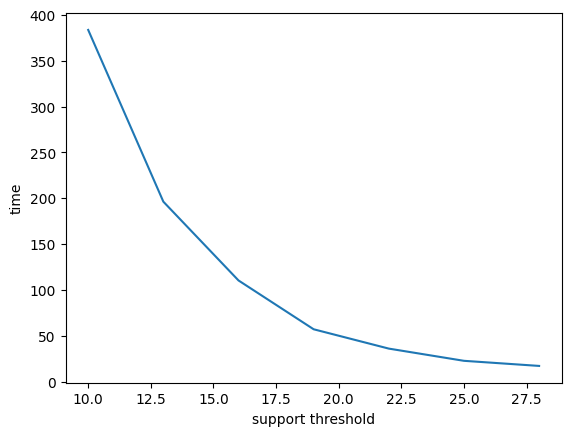

In [30]:
#plt.plot(list(S), apriori_times)
plt.plot(list(S), son_times)
#plt.legend(['apriori','SON'])
plt.ylabel('time')
plt.xlabel('support threshold')
plt.show()

# Time and different partition number

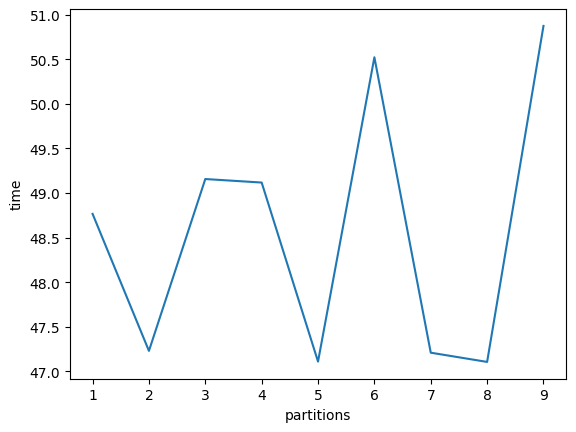

In [26]:
r = 100000
S = 20
baskets = baskets_full.sample(r, random_state = 42)

tp_results = []
tp_times = []
partitions = range(1,10)
for p in partitions:
  spark = SparkSession.builder.master("local["+str(p)+"]").getOrCreate()
  spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
  sc = spark.sparkContext
  RDD = sc.parallelize(baskets)
  t, result = son(RDD,S,r)
  tp_results.append(result)
  tp_times.append(t)

plt.plot(list(partitions), tp_times)
plt.ylabel('time')
plt.xlabel('partitions')
plt.show()